# Full regional extraction
Here we will extract cells from a variable size continuous polygon.
This will be the first step in doing a full regionalising model.
> For simplicity we restrict the list to only one polygon

In [1]:
#Loading things as usual
#%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Ok, the approach will be this
1. Let $p=(x,y)$ in Mexico
2. Create a buffer size list (maybe exponential) not to big.
4. Generate a list of polygons according to this list.
5. Overlay with the mesh (lowest resolution)
6. Extract cells, or cell ids.


In [2]:
from django.contrib.gis.geos import Point, Polygon
#coord = -99.76
#coord = 17.55
#xcoord = -98.219
#ycoord = 19.05
xcoord = -97.237
ycoord = 19.482
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,2,10)
polys = map(lambda r : p.buffer(r),radii)


In [3]:
## Intersect the polygons with the cells to obtain the targets

In [4]:
from mesh.models import initMesh

In [5]:
mexmesh = initMesh(11)

DEBUG Changed MESH TABLE SPACE


In [6]:
## restrict the polygons to the polygon n 3
polys = [polys[9]]
intersected_cells = map(lambda poly : mexmesh.objects.filter(cell__intersects=poly),polys)

In [7]:
# Number of selected cells in each buffer
values = map(lambda l : list(l.values_list('id',flat=True)),intersected_cells)

In [8]:
## Change to network database
from traversals.strategies import idsToCells
cells = map(lambda level : list(idsToCells(level)),values)

INFO Compiling Query and asking the Graph Database


In [9]:
### Sumon the LToL
# Following example from Data generator
from drivers.tree_builder import buildTreeNeo
trees = []
for list_of_cells in cells:
    %time trees.append(map(lambda c : buildTreeNeo(c),list_of_cells))


CPU times: user 39min 29s, sys: 1min 14s, total: 40min 43s
Wall time: 45min 32s


In [10]:
## Pseudo Presence bursea 
from traversals import strategies as st
## Get all models, environmental variables
from raster_api.models import raster_models_dic

In [11]:
rstmods = raster_models_dic.keys()

In [12]:
%time data = map(lambda cell : st.getEnvironmentalCovariatesFromListOfCells(cell,vars=rstmods),cells)

CPU times: user 1min 24s, sys: 1.57 s, total: 1min 25s
Wall time: 24min 17s


In [13]:
## Insert cells ids
## be carefull with the nested list given by the several polygons
ids = pd.DataFrame(map(lambda cell : cell.id,cells[0]),columns=['cell_ids'])
newdata = pd.concat([ids,data[0]],axis=1)

In [14]:
ocs = map(lambda t : t.occurrences, trees[0])
ocs = reduce(lambda a,b : a + b , ocs)
big_tree = TreeNeo(ocs)

## This is for generating a dataset for birds. We will select the family that is more extensively distributed spatially.
For this we will do:

In [15]:
### Pick birds branch, root it, then calculate the branches
birds = big_tree.to_Animalia.to_Chordata.to_Aves.plantTreeNode()
# Let's see  which birds are more frequent
%time birds.countNodesFrequenciesOnList(trees[0])
birds.families.sort(key=lambda x : x.n_presences_in_list,reverse=True)
birds.orders.sort(key=lambda x : x.n_presences_in_list,reverse=True)

CPU times: user 11min 29s, sys: 272 ms, total: 11min 29s
Wall time: 11min 30s


## Let's build the Pseudo presence absence

First, Let be bursera the node we want to model

In [16]:
from drivers.graph_models import Phylum, Genus, Family

In [17]:
## Uncomment for Pines example
#abies = pickNode(Genus,'Abies')
#pinophyta = abies.getParent().getParent().getParent().getParent()
#plant = pinophyta.getParent()
#Luca = plant.getParent()
#pinos_l = []
#abies_l = []
#luca_l = []
#plants_l = []
#for ltree in trees:
#    %time pinos_l.append(st.getPresencesForNode(pinophyta,ltree))
#    %time abies_l.append(st.getPresencesForNode(abies,ltree))
#    %time luca_l.append(st.getPresencesForNode(Luca,ltree))
#    %time plants_l.append(st.getPresencesForNode(plant,ltree))

In [18]:
## This is for the birds example
Tyrannidae = pickNode(Family,'Tyrannidae')
passeriformes = Tyrannidae.getParent()
aves = passeriformes.getParent()
Luca = aves.getParent().getParent().getParent()
tyrannidae_l = []
passeriformes_l = []
luca_l = []
aves_l = []
for ltree in trees:
    %time tyrannidae_l.append(st.getPresencesForNode(Tyrannidae,ltree))
    %time passeriformes_l.append(st.getPresencesForNode(passeriformes,ltree))
    %time luca_l.append(st.getPresencesForNode(Luca,ltree))
    %time aves_l.append(st.getPresencesForNode(aves,ltree))

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 70.4 ms
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 56.7 ms
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 29.5 ms
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 41.1 ms


## Extract covariates

In [19]:
from utilities import data_extraction as de
centers_nested = map(lambda c : map(lambda p : p.centroid, c),cells)
from ecoregions.models import TerrEcoregions,InegiIV

In [20]:
## Calculate tipo de vegetacion
#vegie_types = map(lambda lp : extractVegetation(lp),centers_nested)
from ecoregions.models import TerrEcoregions,InegiIV,LandUseConabio
vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],
           [InegiIV,['covid','name'],[np.nan,'NaN']],
           [LandUseConabio,['cov_id','tipos'],[np.nan,'NaN']]
          ]
vegie_types = map(lambda lp : de.extractSeveralVectorFeatures(lp,vectsel),centers_nested)

INFO extracting info from: <class 'ecoregions.models.TerrEcoregions'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.InegiIV'> this can take some minutes
INFO extracting info from: <class 'ecoregions.models.LandUseConabio'> this can take some minutes


In [21]:
## uncomment for pines data set
#datos = zip(luca_l,plants_l,pinos_l,abies_l,[newdata],vegie_types)

## For birds dataset
datos = zip(luca_l,aves_l,passeriformes_l,tyrannidae_l,[newdata],vegie_types)


In [22]:
## Compile the dataframe and convert to geopandas
dd = map(lambda (l,pl,pn,ab,dat,veg) : pd.concat([l,pl,pn,ab,dat,veg],axis=1),datos)
dd = map(lambda d : st.toGeoDataFrame(d,xcoord_name='Longitude',ycoord_name='Latitude'),dd)

In [23]:
#for i,d in enumerate(dd):
#    cad = '/outputs/presence_only_models/data/root_p3/%s.csv'%i
#    print(cad)
#    d.to_csv(cad,encoding='utf8')

In [24]:
d = dd[0]

In [25]:
plt.rcParams['figure.figsize'] = [10, 10]

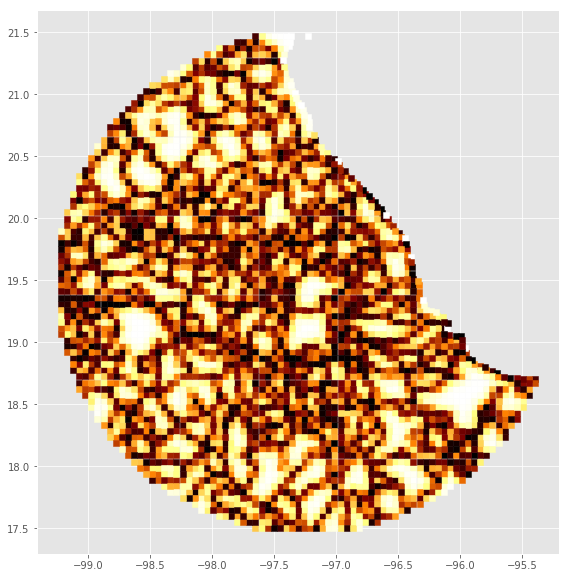

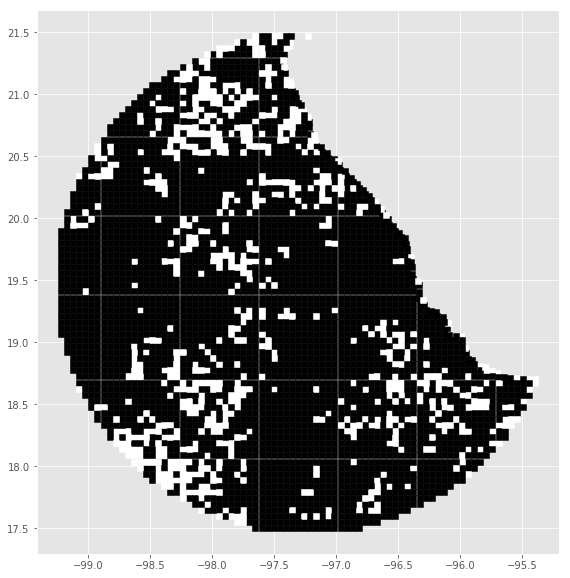

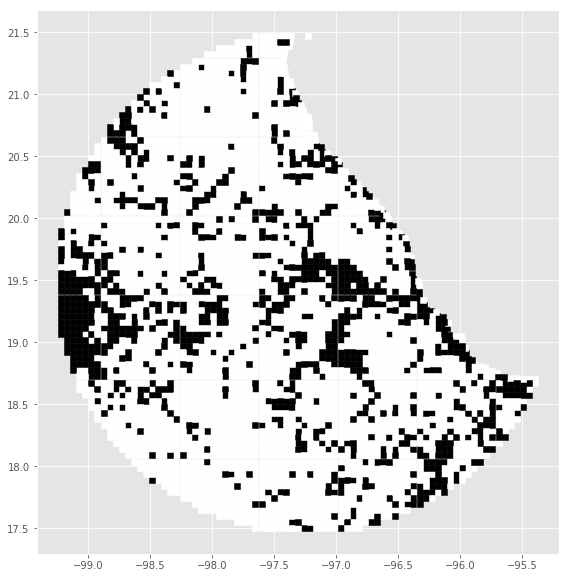

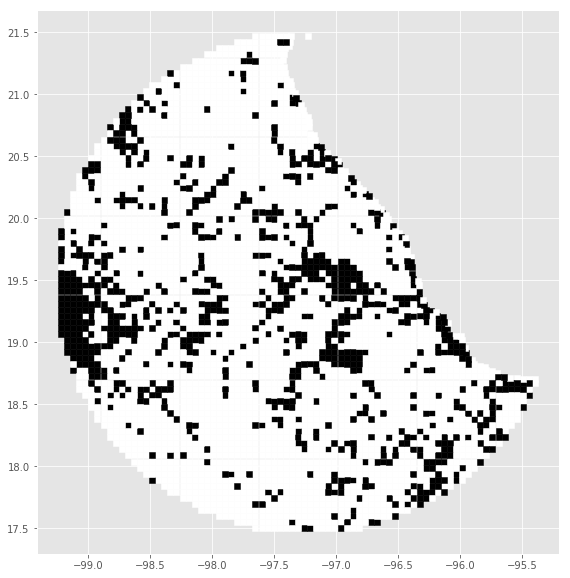

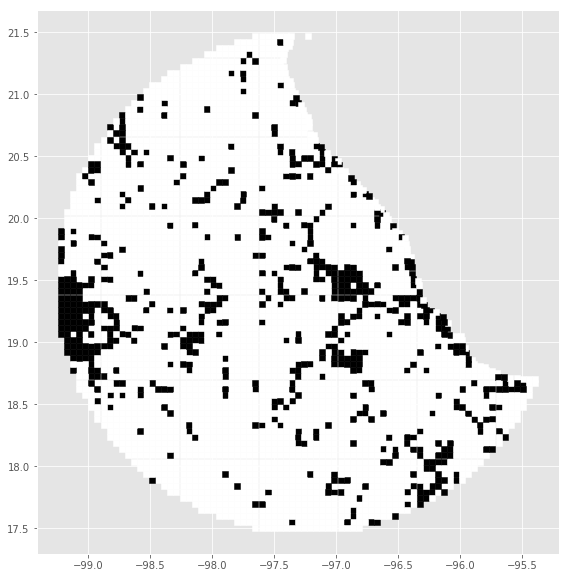

In [26]:
d.plot(column='Dist.to.road_m',marker='s',cmap=plt.cm.afmhot)
d.plot(column='LUCA',cmap=plt.cm.Greys,marker='s')
d.plot(column='Aves',cmap=plt.cm.Greys,marker='s')
d.plot(column='Passeriformes',cmap=plt.cm.Greys,marker='s')
d.plot(column='Tyrannidae',cmap=plt.cm.Greys,marker='s')
#d.plot(column='Plantae',cmap=plt.cm.Greys,marker='s')
#d.plot(column='Pinophyta',cmap=plt.cm.Greys,marker='s')
#d.plot(column='Abies',cmap=plt.cm.Greys,marker='s')


## This is for getting  the neighbour structure

In [27]:
G = st.LatticeToNetworkx(cells[0])

In [28]:
lpositions = map(lambda n : (n.centroid.x, n.centroid.y), cells[0])
cellsids = map(lambda c : c.id, cells[0])
positions = dict(zip(cellsids,lpositions))


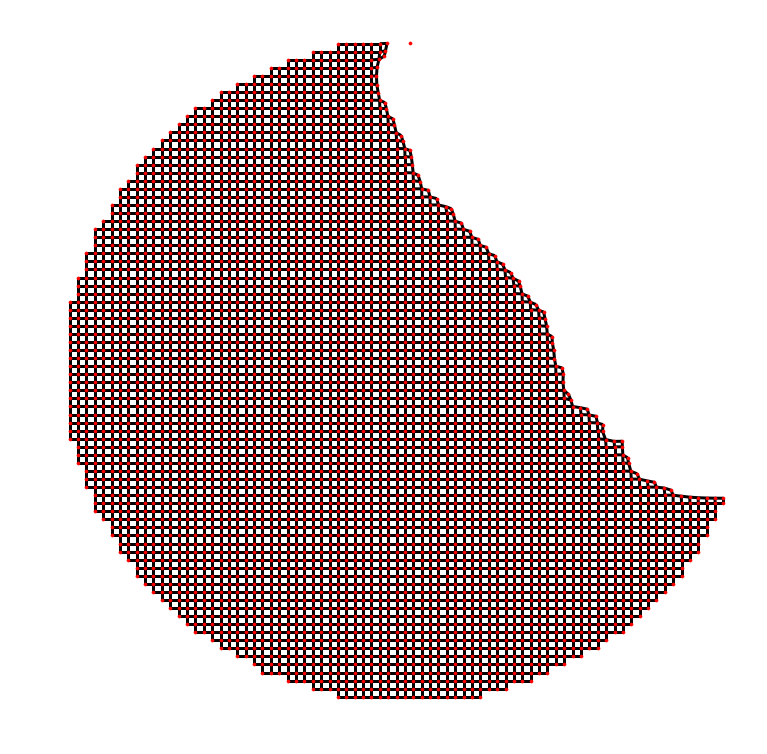

In [29]:
import networkx as nx
## Plot it
options = {
'node_size': 10,
'width': 3,}
nx.draw(G,positions,**options)

In [30]:
## Format the graph to fit with the STAN CAR model, i.e. lists of edges

In [31]:
edges = G.edges()

In [32]:
sorted_edges = edges.keys()

In [33]:
sorted_edges.sort(key=lambda x : x[0])

In [34]:
data_sortd_cells = d.sort_values(by=['cell_ids'])

In [35]:
data_sortd_cells.replace('N.A.',np.nan,inplace=True)

In [36]:
xx = data_sortd_cells[['LUCA', 'Elevation_m','cell_ids']]

In [37]:
## Remove NAs
newx = xx.dropna(subset=['Elevation_m'])
# Convert variables to int
y = newx.LUCA.values.astype('int')
x = newx.Elevation_m
## Reset index for newx
n = x.shape[0]
newx.reset_index(inplace=True)

In [38]:
## Remove Nas in Y , this is temporary
yy = newx.LUCA.fillna(0).astype('int')

# CLEAN THIS FILE 

## Example for running the CAR model in python


In [306]:
node1 ,  node2 = zip(*sorted_edges)

In [307]:
nodes = pd.DataFrame(sorted_edges,columns=['node1','node2'])

In [308]:
## Remove nodes that are not in the newx
nodes = nodes[nodes['node1'].isin(newx.cell_ids)]
nodes = nodes[nodes['node2'].isin(newx.cell_ids)]

In [309]:
max(nodes.node1)

254342

In [356]:
## Get index node, needed for the stan program to run
idx_node1  = map(lambda node : newx[newx.cell_ids == node].index.item()+1 , nodes.node1)
idx_node2  = map(lambda node : newx[newx.cell_ids == node].index.item()+1 , nodes.node2)

In [311]:
max(idx_node1)

4047

In [312]:
newx.shape

(4048, 4)

In [313]:
N_edges = nodes.shape[0]
N = newx.shape[0]


In [357]:
data = {'N' : N,
        'N_edges' : N_edges,
       'node1': idx_node1,
       'node2': idx_node2,
       'y': yy,
       'x': x,
       }

In [315]:
import pystan

In [316]:
stan_code = """
functions {
  real icar_normal_lpdf(vector phi, int N, int[] node1, int[] node2) {
    return -0.5 * dot_self(phi[node1] - phi[node2])
      + normal_lpdf(sum(phi) | 0, 0.001 * N);
 }
}
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
  int<lower=0,upper=1> y[N];              // count outcomes
  vector<lower=-100>[N] x;           // coefficient
}

parameters {
  real beta0;             // intercept
  real beta1;             // slope
  real<lower=0> sigma;    // spatial standard deviation
  vector[N] phi_raw;         // spatial effects
}
transformed parameters { 
  vector[N] phi = sigma * phi_raw;
  }
model {
  y ~ bernoulli_logit(beta0 + beta1 * x + phi);
  beta0 ~ normal(0.0, 10^2.5);
  beta1 ~ normal(0.0, 10^2.5);
  target += -3*log(sigma) - 1/(sigma)^2;  // Stan equiv of BUGS model prior on tau
  phi_raw ~ icar_normal_lpdf(N, node1, node2);
}
generated quantities {
  real tau = sigma^-2;
}

"""

In [317]:
%time sm = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b36703c5e4267af559a6132969b8359 NOW.


CPU times: user 1.39 s, sys: 572 ms, total: 1.96 s
Wall time: 50.3 s


In [347]:
%time fit = sm.sampling(data=data, iter=10)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 204 ms, sys: 1.16 s, total: 1.36 s
Wall time: 2.04 s


# It worked!

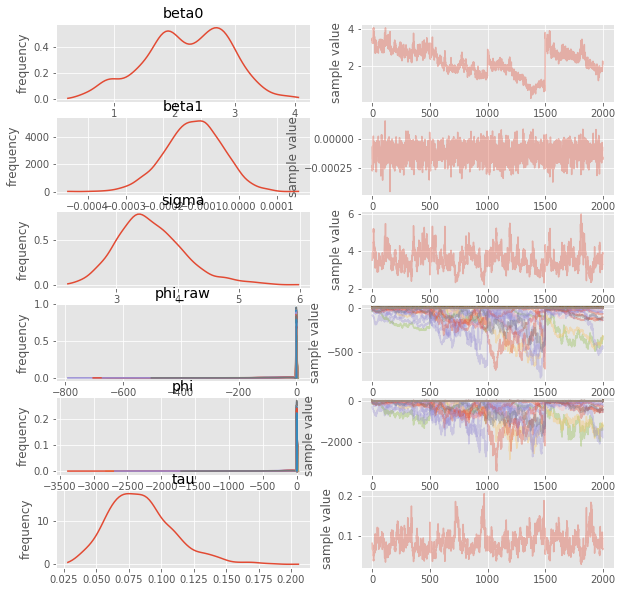

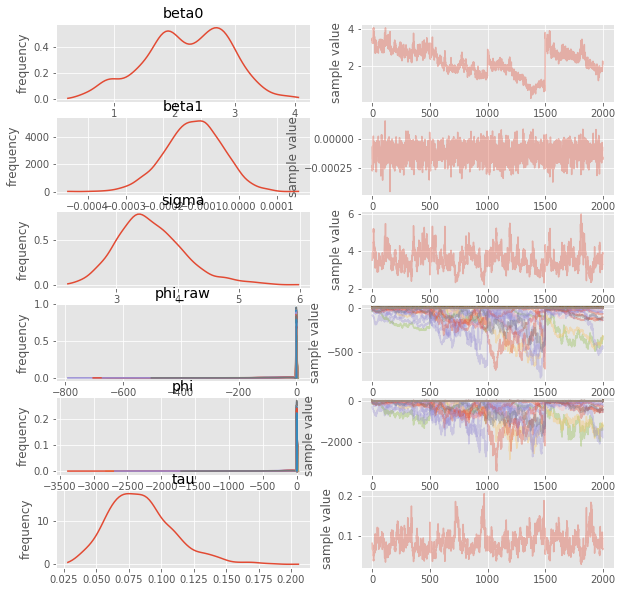

In [204]:
fit.plot()

In [319]:
tuto = fit.extract(permuted=True)

In [350]:
tuto.keys()

[u'beta0', u'beta1', u'sigma', u'phi_raw', u'phi', u'tau', u'lp__']

In [320]:
mphis = np.mean(tuto['phi'],axis=0)

In [322]:
newx['newmphis'] = mphis

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [326]:
tomerge = newx.set_index('cell_ids')

In [329]:
stan_resoo = d.join(tomerge.mphis,on='cell_ids')

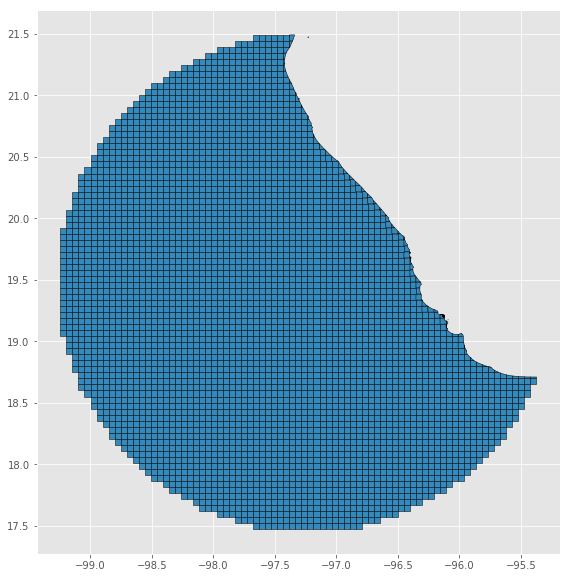

In [331]:
## Read geometry
import geopandas as gpd
## Geometry file
geometryfile = "/outputs/training_data_sample_puebla_p9_geometry.json"
## Readfile
gg = gpd.read_file(geometryfile)
gg.set_index('indx',inplace=True)
plt.rcParams['figure.figsize'] = [10, 10]
gg.plot(edgecolor='black')

In [334]:
phispoly = gg.join(tomerge)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
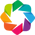

In [335]:
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs
gv.extension('bokeh','matplotlib')

In [337]:
phi = gv.Polygons(phispoly,vdims=['mphis'])

In [345]:
height=800
width=800
phi.opts(
        line_width=0.001,
        line_alpha = 0.2,
        tools=['hover'],
        width = width,
        height = height,
        colorbar = True,
        #clim = clim,        
        colorbar_position = 'bottom',
        alpha = 1.0,
        )

:Polygons   [Longitude,Latitude]   (mphis)

In [237]:

type(newx.cell_ids[0])

numpy.float64

In [219]:
d.join(newx,on='cell_ids')

In [35]:
#Order the nodes according to their id value, just ot mke it expl
ordered_nodes_list = G.nodes()
ordered_nodes_list.sort(key=lambda c : c.id)
#ordered_nodes_list.sort()
M = nx.adjacency_matrix(G,nodelist=ordered_nodes_list)

AttributeError: 'NodeView' object has no attribute 'sort'

In [38]:
nodes =G.nodes()

In [ ]:
plt.imshow(M.toarray())

In [ ]:
Ok, we need to do something here to plot the data

Also try the other method el BYM2



In [2]:
trees

NameError: name 'trees' is not defined

## Save it to posterity

In [103]:
## Let's save it in Redis
import redis
import pickle
conn = redis.StrictRedis(host='redis',password='biospytial.')

In [104]:
#tag = 't-guerrero-p4'
tag = 't-puebla-p9-abies-pinophyta'
#tag = 't-puebla-p3-abies-pinophyta'
#tag = 't-puebla-p4-abies-pinophyta'
#tag = 't-puebla-p2-abies-pinophyta'
conn.set(tag,pickle.dumps(d))

True

In [51]:
## Save a CSV file for Pines- Dataset (uncomment)
#d.to_csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv",encoding='utf8')
## Save a CSV file for Birds dataset
d.to_csv("/outputs/training_data_sample_puebla_p9_tyrannidae_birds.csv",encoding='utf8')

In [52]:
d.shape

(4061, 24)

### Save the Adjancency matrix, BE CAREFULL ORDER FIRST!!


In [41]:
#mat_filename = "/outputs/training_data_sample_puebla_p4_abies_pinophyta_adjmat.npy"
#mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
mat_filename = "/outputs/training_data_sample_puebla_p3_abies_pinophyta_adjmat.npy"
np.save(mat_filename,M.toarray())

In [42]:
# Experimental, pickle network
#tag = 't-puebla-p9-abies-pinophyta-graph'
tag = 't-puebla-p3-abies-pinophyta-graph'
conn.set(tag,pickle.dumps(G))

True

In [ ]:
Load it R apply the CAR model.